<a href="https://colab.research.google.com/github/vamsijan/audio_ravdess/blob/main/ABSA_SEM2015_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import csv
import xml.etree.ElementTree as ET

In [5]:
tree = ET.parse("/content/ABSA-15_Restaurants_Train_Final.xml")
root = tree.getroot()

In [7]:
csv_file = open("restaurants.csv", "w", newline="")
csv_writer = csv.writer(csv_file)

In [8]:
csv_writer.writerow(["text", "target", "category", "polarity", "from", "to"])

39

In [9]:
for sentence in root.iter("sentence"):
    sentence_text = sentence.find("text").text
    for opinion in sentence.iter("Opinion"):
        target = opinion.attrib.get("target")
        category = opinion.attrib.get("category")
        polarity = opinion.attrib.get("polarity")
        start = opinion.attrib.get("from")
        end = opinion.attrib.get("to")

        # Write a row in the CSV file
        csv_writer.writerow([sentence_text, target, category, polarity, start, end])

# Close the CSV file
csv_file.close()

print("CSV file created successfully.")

CSV file created successfully.


In [10]:
import pandas as pd

df1 = pd.read_csv('restaurants.csv', encoding='ISO-8859-1')
df1.head()

,text,target,category,polarity,from,to
0,Judging from previous posts this used to be a ...,place,RESTAURANT#GENERAL,negative,51,56
1,"We, there were four of us, arrived at noon - t...",staff,SERVICE#GENERAL,negative,75,80
2,"They never brought us complimentary noodles, i...",NaN,SERVICE#GENERAL,negative,0,0
3,The food was lousy - too sweet or too salty an...,food,FOOD#QUALITY,negative,4,8
4,The food was lousy - too sweet or too salty an...,portions,FOOD#STYLE_OPTIONS,negative,52,60


In [11]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer, PreTrainedModel, PreTrainedTokenizer
import re
#import emoji
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
#from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, GPT2Config
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetModel#
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # convert to lowercase
    text = text.lower()
    # tokenize text
    tokens = nltk.word_tokenize(text)
    # remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # lemmatize text
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # join tokens back into text
    text = ' '.join(tokens)
    return text

df1['clean_text'] = df1['text'].apply(preprocess_text)
#Delete the useless Columns
df1 = df1.drop(["category", "from", "to"], axis=1)

## Delete the polarity than contains CONFLICT, Means that the sentence contains more than one sentiment when it comes to the aspect term
df1.drop(df1[df1.polarity == 'conflict'].index, inplace = True)

df1['polarity'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [13]:
from transformers import RobertaTokenizer, TFRobertaModel

# split data into input and target variables
X = df1['clean_text'].values
y = pd.get_dummies(df1['polarity']).values

# Calculate the maximum sequence length from the input data
max_length = max([len(x.split()) for x in X])
print(f"Max length: {max_length}")

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# create Roberta tokenizer and encode inputs
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')
train_encodings = tokenizer(X_train.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors='np')
val_encodings = tokenizer(X_val.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors='np')

# define early stopping and model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_res_2015.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_sentence': train_encodings['input_ids'], 'input_mask': train_encodings['attention_mask']},
    y_train
)).batch(32).prefetch(1)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_sentence': val_encodings['input_ids'], 'input_mask': val_encodings['attention_mask']},
    y_val
)).batch(32).prefetch(1)

# define input layer with correct name and shape
inputs = {
    'input_sentence': tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_sentence'),
    'input_mask': tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_mask')
}

# define model architecture
roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base')
roberta_embeddings = roberta_model({'input_ids': inputs['input_sentence'], 'attention_mask': inputs['input_mask']})[0]
roberta_embeddings = tf.keras.layers.Dropout(0.2)(roberta_embeddings)
gru_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False))(roberta_embeddings)
gru_output = tf.keras.layers.Dropout(0.2)(gru_output)
attention_output = tf.keras.layers.Attention()([gru_output, gru_output])
output = tf.keras.layers.Dense(3, activation='softmax')(attention_output)
model_ro_res_2015 = tf.keras.models.Model(inputs=inputs, outputs=output)
model_ro_res_2015.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# train model with early stopping and model checkpoint
history = model_ro_res_2015.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint])

Max length: 35


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


42/42 [==============================] - ETA: 0s - loss: 0.8564 - accuracy: 0.6992 
Epoch 1: val_accuracy improved from -inf to 0.75831, saving model to best_model_res_2015.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 815s 18s/step - loss: 0.8564 - accuracy: 0.6992 - val_loss: 0.5888 - val_accuracy: 0.7583
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.7506 
Epoch 2: val_accuracy improved from 0.75831 to 0.86405, saving model to best_model_res_2015.h5
42/42 [==============================] - 780s 19s/step - loss: 0.6219 - accuracy: 0.7506 - val_loss: 0.3920 - val_accuracy: 0.8640
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8299 
Epoch 3: val_accuracy improved from 0.86405 to 0.87613, saving model to best_model_res_2015.h5
42/42 [==============================] - 767s 18s/step - loss: 0.4562 - accuracy: 0.8299 - val_loss: 0.3755 - val_accuracy: 0.8761
Epoch 4/50
42/42 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8526 
Epoch 4: val_accuracy improved from 0.87613 to 0.88520, saving model to best_model_res_2015.h5
42/42 [==============================

In [14]:
df1

,text,target,polarity,clean_text
0,Judging from previous posts this used to be a ...,place,negative,judging previous post used good place longer
1,"We, there were four of us, arrived at noon - t...",staff,negative,four u arrived noon place empty staff acted li...
2,"They never brought us complimentary noodles, i...",NaN,negative,never brought u complimentary noodle ignored r...
3,The food was lousy - too sweet or too salty an...,food,negative,food lousy sweet salty portion tiny
4,The food was lousy - too sweet or too salty an...,portions,negative,food lousy sweet salty portion tiny
...,...,...,...,...
1649,I have to say I have never had a disapointing ...,meal,positive,say never disapointing meal
1650,We could have made a meal of the yummy dumplin...,dumplings,positive,could made meal yummy dumpling dumpling menu
1651,"Luckily we saved room for the BBQ Salmon, Sea ...",BBQ Salmon,positive,luckily saved room bbq salmon sea bass crispy ...
1652,"Luckily we saved room for the BBQ Salmon, Sea ...",Sea Bass,positive,luckily saved room bbq salmon sea bass crispy ...


In [15]:
from sklearn.preprocessing import LabelBinarizer
# evaluate model
y_pred = model_ro_res_2015.predict(val_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')

# Convert y_true and y_pred to one-hot encoded format
lb = LabelBinarizer()
y_true_one_hot = lb.fit_transform(y_true)
y_pred_one_hot = lb.transform(y_pred)

auc = roc_auc_score(y_true_one_hot, y_pred_one_hot, average='weighted', multi_class='ovr')
print('F1 score:', f1)
print('AUC-ROC score:', auc)

11/11 [==============================] - 65s 4s/step
F1 score: 0.8817984487284977
AUC-ROC score: 0.8439922480620156


11/11 [==============================] - 55s 5s/step
AUC-ROC scores: [0.93495805 0.79938272 0.93510956]


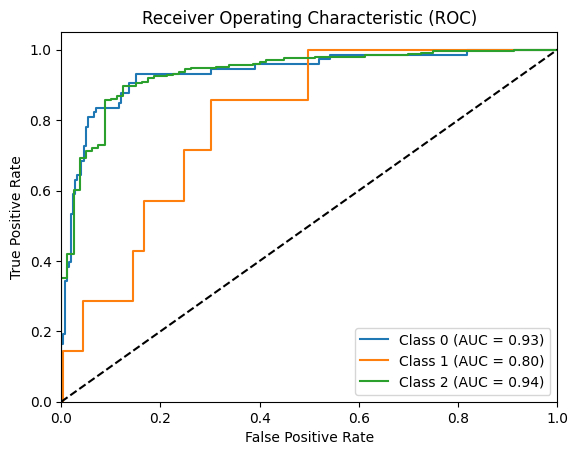

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for validation set
y_pred_proba = model_ro_res_2015.predict(val_dataset)

# Calculate AUC-ROC scores
auc_roc_scores = roc_auc_score(y_val, y_pred_proba, average=None, multi_class='ovr')
print('AUC-ROC scores:', auc_roc_scores)

# Plot AUC-ROC curves for each class
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()